In [6]:
# ================================================================
# Import required libraries
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from numba import njit
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
from scipy.integrate import cumulative_trapezoid
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D

In [2]:
# ================================================================
# Inflationary potential and its derivatives
# ================================================================

# Potential with a Gaussian bump defined according to equation (17)
V0 = 0.1432449730952887
m = 0.5
A = 1.876 * 10**(-3)
B = 1.993 * 10**(-2)
f0 = 2.005

# All functions are JIT-compiled using numba for performance,
# since they are called repeatedly during ODE integration.
@njit
def V(f):
    return V0 * f**2 / (m**2 + f**2) * (1 + A * np.exp(-(f - f0)**2 / (2 * B**2)))

@njit
def dotV(f):
    return -A*V0*f**2*(2*f - 2*f0)*np.exp(-(f - f0)**2/(2*B**2))/(2*B**2*(f**2 + m**2)) - 2*V0*f**3*(A*np.exp(-(f - f0)**2/(2*B**2)) + 1)/(f**2 + m**2)**2 + 2*V0*f*(A*np.exp(-(f - f0)**2/(2*B**2)) + 1)/(f**2 + m**2)

@njit
def ddotV(f):
    return 2*A*V0*f**3*(2*f - 2*f0)*np.exp(-(f - f0)**2/(2*B**2))/(B**2*(f**2 + m**2)**2) - A*V0*f**2*np.exp(-(f - f0)**2/(2*B**2))/(B**2*(f**2 + m**2)) - 2*A*V0*f*(2*f - 2*f0)*np.exp(-(f - f0)**2/(2*B**2))/(B**2*(f**2 + m**2)) + A*V0*f**2*(2*f - 2*f0)**2*np.exp(-(f - f0)**2/(2*B**2))/(4*B**4*(f**2 + m**2)) + 8*V0*f**4*(A*np.exp(-(f - f0)**2/(2*B**2)) + 1)/(f**2 + m**2)**3 - 10*V0*f**2*(A*np.exp(-(f - f0)**2/(2*B**2)) + 1)/(f**2 + m**2)**2 + 2*V0*(A*np.exp(-(f - f0)**2/(2*B**2)) + 1)/(f**2 + m**2)

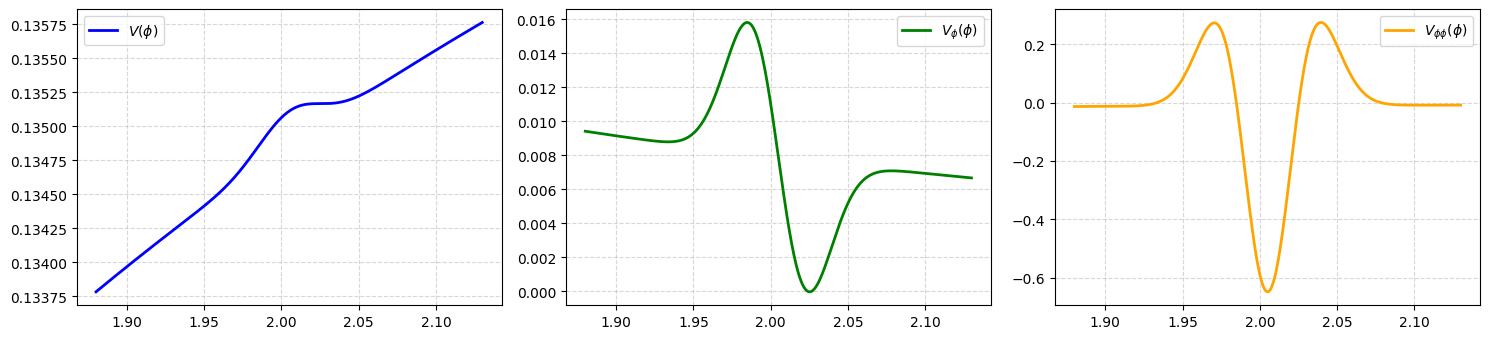

In [4]:
# ================================================================
# Plot the inflationary potential and its derivatives
# ================================================================

phi = np.linspace(f0 - m**2/2, f0 + m**2/2, 499)

# Create 1 row, 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3.5), sharex=True)

# ------------------------------------------------
# Plot the potential V(φ)
# ------------------------------------------------
axes[0].plot(phi, V(phi), color='blue', linewidth=2, label=r'$V(\phi)$')
#axes[0].set_title(r'$V(\phi)$')
axes[0].grid(True, linestyle='--', alpha=0.5)
axes[0].legend()

# ------------------------------------------------
# Plot the first derivative V_φ(φ)
# ------------------------------------------------
axes[1].plot(phi, dotV(phi), color='green', linewidth=2, label=r'$V_{\phi}(\phi)$')
#axes[1].set_title(r'$V_{\phi}(\phi)$')
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].legend()

# ------------------------------------------------
# Plot the second derivative V_φφ(φ)
# ------------------------------------------------
axes[2].plot(phi, ddotV(phi), color='orange', linewidth=2, label=r'$V_{\phi\phi}(\phi)$')
#axes[2].set_title(r'$V_{\phi\phi}(\phi)$')
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].legend()

# Adjust spacing
plt.tight_layout()

plt.show()

In [5]:
# ================================================================
# Background evolution solver
# ================================================================
# The dynamical variables are:
#   f  = φ          (scalar field)
#   fp = dφ/dN      (derivative of the field with respect to e-folds)

def eqphi(t, fc):
    f = fc[0]
    fp = fc[1]
    eps1 = fp**2 / 2.0 # First Hubble slow-roll parameter: ε₁ = (1/2)(dφ/dN)²
    fdot = np.zeros(2)
    fdot[0] = fp
    # Klein–Gordon equation rewritten in terms of e-folds
    fdot[1] = (dotV(f) / V(f) + fp) * (eps1 - 3.0)
    return fdot

# Initial conditions and integration range
# The initial velocity is fixed by the slow-roll approximation: dφ/dN ≈ -sqrt(2 ε₁)
fin = [f0 + 0.5, -np.sqrt(2 * 0.0006659)] # [φ_initial, (dφ/dN)_initial]
# Integration range in e-folds
# The final hypersurface does not need to be exactly 60 e-folds after the beginning of inflation; it is sufficient to stop well inside the final slow-roll phase.
n1 = 0 
n2 = 25

# Note: keep max_step small to ensure high resolution for interpolation later
solb = solve_ivp(lambda t, fc: eqphi(t, fc), (n1, n2), fin, method='DOP853', max_step=0.0001)

In [6]:
# ================================================================
# Extract background solution and prepare derived quantities
# ================================================================
#
# In this section we extract the background solution obtained from the ODE solver and construct all background quantities required for:
#   - Mukhanov–Sasaki equation
#   - Gradient expansion integrals
#   - δN formalism with and without gradient corrections

# The time variable is the number of e-folds.
t_bg = np.ascontiguousarray(solb.t) # e-fold time array
f_values = solb.y[0]    # background field φ(N)
fp_values = solb.y[1]   # dφ/dN

# Potential and its derivatives
V_vals = V(f_values)
dotV_vals = dotV(f_values)
ddotV_vals = ddotV(f_values)

# Second and third derivatives of the field with respect to N obtained from the background equations of motion
fpp_values = (dotV_vals / V_vals + fp_values) * (fp_values**2 / 2 - 3)
fppp_values = (
    (fp_values * ddotV_vals/V_vals - fp_values*(dotV_vals/V_vals)**2 + fpp_values) 
    * (fp_values**2/2 - 3)
    + (dotV_vals/V_vals + fp_values) * (fp_values * fpp_values)
)

e1_values = np.ascontiguousarray(fp_values**2 / 2)  # First slow-rol parameter
H_values = np.ascontiguousarray(np.sqrt(V_vals / (3 - e1_values)))  # Hubble parameter
# Second slow-roll parameter and its derivative
e2_values = 2 * fpp_values / fp_values
dote2_values = -2 * fpp_values**2 / fp_values**2 + 2 * fppp_values / fp_values
# z''/(a^2 H^2 z) term appearing in the Mukhanov–Sasaki equation
zppoz_values = np.ascontiguousarray(
    2 - e1_values + 3/2 * e2_values + 1/4 * e2_values**2 - 1/2 * e1_values * e2_values + 1/2 * dote2_values
)

# Interpolators for background quantities
H_interp = interp1d(t_bg, H_values, kind='linear', fill_value="extrapolate")
e1_interp = interp1d(t_bg, e1_values, kind='linear', fill_value="extrapolate")
zppoz_interp = interp1d(t_bg, zppoz_values, kind='linear', fill_value="extrapolate")
f_interp = interp1d(t_bg, f_values, kind='linear', fill_value="extrapolate")
fp_interp = interp1d(t_bg, fp_values, kind='linear', fill_value="extrapolate")
fpp_interp = interp1d(t_bg, fpp_values, kind='linear', fill_value="extrapolate")
e2_interp = interp1d(t_bg, e2_values, kind='linear', fill_value="extrapolate")

# End-of-inflation quantities
e1_end = e1_values[-1]
phi_end_target = f_values[-1]


# ================================================================
# Gradient expansion integrals
# ================================================================
# This function constructs the nested time integrals appearing in the gradient expansion of curvature perturbations (see Eq. (6))
# These integrals are required for:
#   - Higher-order matching method
#   - δN formalism with gradient corrections
def build_k2_corrections(nj):
    # Locate index
    idx_start = np.searchsorted(t_bg, nj)
    if idx_start >= len(t_bg) - 2:
        idx_start = max(0, len(t_bg) - 10)

    t_slice = t_bg[idx_start:]
    a_slice = a_bg[idx_start:]
    e1_slice = e1_values[idx_start:]
    H_slice = H_values[idx_start:]

    # Measures
    measure_z2_slice      = (2.0 * a_slice * e1_slice) / H_slice        
    measure_inv_z2_slice  = 1.0 / (2.0 * a_slice**3 * H_slice * e1_slice)  

    # 1. nad_0 (I1) - zeroth order non-adiabatic correction
    I1_slice = cumulative_trapezoid(measure_inv_z2_slice, t_slice, initial=0.0)
    nad_0_func = interp1d(t_slice, I1_slice, kind='linear', bounds_error=False, fill_value=(0.0, I1_slice[-1]))

    # 2. ad_k2 (J2) - k^2 order adiabatic correction
    J1_slice = cumulative_trapezoid(measure_z2_slice, t_slice, initial=0.0)
    integrand_ad_k2 = measure_inv_z2_slice * J1_slice
    J2_slice = cumulative_trapezoid(integrand_ad_k2, t_slice, initial=0.0)
    ad_k2_func = interp1d(t_slice, J2_slice, kind='linear', bounds_error=False, fill_value=(0.0, J2_slice[-1]))

    # 3. nad_k2 (K3) - k^2 order non-adiabatic correction
    integrand_nad_mid = measure_z2_slice * I1_slice
    K2_slice = cumulative_trapezoid(integrand_nad_mid, t_slice, initial=0.0)
    integrand_nad_k2 = measure_inv_z2_slice * K2_slice
    K3_slice = cumulative_trapezoid(integrand_nad_k2, t_slice, initial=0.0)
    nad_k2_func = interp1d(t_slice, K3_slice, kind='linear', bounds_error=False, fill_value=(0.0, K3_slice[-1]))

    # 4. ad_k4 (L4) - k^4 order adiabatic correction
    integrand_ad_mid_k4 = measure_z2_slice * J2_slice
    L3_slice = cumulative_trapezoid(integrand_ad_mid_k4, t_slice, initial=0.0)
    integrand_ad_k4 = measure_inv_z2_slice * L3_slice
    L4_slice = cumulative_trapezoid(integrand_ad_k4, t_slice, initial=0.0)
    ad_k4_func = interp1d(t_slice, L4_slice, kind='linear', bounds_error=False, fill_value=(0.0, L4_slice[-1]))

    # 5. nad_k4 (M5) - k^4 order non-adiabatic correction
    integrand_nad_mid_k4 = measure_z2_slice * K3_slice
    M4_slice = cumulative_trapezoid(integrand_nad_mid_k4, t_slice, initial=0.0)
    integrand_nad_k4 = measure_inv_z2_slice * M4_slice
    M5_slice = cumulative_trapezoid(integrand_nad_k4, t_slice, initial=0.0)
    nad_k4_func = interp1d(t_slice, M5_slice, kind='linear', bounds_error=False, fill_value=(0.0, M5_slice[-1]))

    return nad_0_func, ad_k2_func, nad_k2_func, ad_k4_func, nad_k4_func


# ================================================================
# Klein–Gordon equation with source terms
# ================================================================
# This is constructed from equation (14)
def eqphi_with_source(t, fc, nj, kj, Hj, zj, R_match, Rp_match, mode, correction_funcs, mode_arrays):
    # Unpack arrays for mode functions. These are used for \delta N formalism with full gradient interactions
    t_ad, uad_vals, t_nad, unad_vals = mode_arrays
    
    # Unpack correction functions - These are corrections added to the source term order by order
    f_nad_0, f_ad_k2, f_nad_k2, _, _ = correction_funcs
    
    f = fc[0]
    fp = fc[1]
    eps1 = fp**2 / 2.0
    
    # Different values of `mode` correspond to different truncation schemes of the gradient expansion:
    #
    #   mode = 0   : standard δN (no gradient corrections)
    #   mode = 1   : zeroth-order adiabatic correction
    #   mode = 2   : zeroth-order non-adiabatic correction
    #   mode = 3   : k² adiabatic correction
    #   mode = 4   : k² non-adiabatic correction
    #   mode = 100 : full gradient interaction (numerical mode functions)
    
    ad_corrections = 0.0
    nad_corrections = 0.0
    
    if mode == 1:
        ad_corrections = 1.0
        nad_corrections = 0.0
        
    elif mode == 2:
        ad_corrections = 1.0
        nad_corrections = zj**2 * f_nad_0(t)
        
    elif mode == 3:
        ad_corrections = 1.0 - (kj**2) * f_ad_k2(t)
        nad_corrections = zj**2 * f_nad_0(t)
        
    elif mode == 4:
        ad_corrections = 1.0 - (kj**2) * f_ad_k2(t)
        nad_corrections = zj**2 * (f_nad_0(t) - (kj**2) * f_nad_k2(t))
        
    elif mode == 100:
        ad_corrections = np.interp(t, t_ad, uad_vals)
        nad_corrections = np.interp(t, t_nad, unad_vals)
    
    # Add source term to KG equation
    # Here we use the relation k = sigma a H
    numerator = (dotV(f) 
                 + (sigma * Hj * np.exp(nj-t))**2 * R_match * fp * ad_corrections
                 + (sigma * Hj * np.exp(nj-t))**2 * Rp_match * fp * nad_corrections)
                 
    fdot = np.empty(2)
    fdot[0] = fp
    fdot[1] = ((numerator / V(f)) + fp) * (eps1 - 3.0) 
    return fdot

# This event function terminates the ODE solver when the field reaches the final uniform-density hypersurface, defined by φ = φ_end_target.
# The time at which this occurs gives the total number of e-folds realized from the matching time.
def event_reached_end(t, y):
    return y[0] - phi_end_target
event_reached_end.terminal = True
event_reached_end.direction = 0

# ================================================================
# Number of e-folds until the end of inflation
# ================================================================
# This function evolves the sourced background equations from the matching time until the final hypersurface and returns the total number of e-folds realized.
def get_N_end_val(phi_in, phiN_in, nj, kj, R_match, Rp_match, Hj, zj, correction_funcs, mode_arrays, mode):
    t_span = (nj, nj + (n2 - n1))
    init = [phi_in, phiN_in]

    sol = solve_ivp(
        lambda t, y: eqphi_with_source(t, y, nj, kj, Hj, zj, R_match, Rp_match, mode, correction_funcs, mode_arrays),
        t_span,
        init,
        method='DOP853',
        events=[event_reached_end],
        # Control the accuracy of N derivatives
        rtol=1e-15,
        atol=1e-16
    )

    if sol.status == 1 and len(sol.t_events[0]) > 0:
        return sol.t_events[0][0]
    else:
        return np.nan


# ================================================================
# Gradient and Hessian of N (δN formalism)
# ================================================================
# This function computes first and second derivatives of the number of N with respect to the integration constants.
# These derivatives are required for computing:
#   - Power spectrum
#   - Equilateral-type non-Gaussianity parameter
def get_hessian_and_gradient(n_match, kj, Hj, zj, phi_bg, phiN_bg, R_match, Rp_match, dphi_flat, dphiN_flat, correction_funcs, mode_arrays, mode):
    # Base Values
    base_vars = np.array([phi_bg, phiN_bg, 0.0, 0.0])
    # In some models, perturbing initial conditions in the wrong direction can cause the field trajectory to miss the final hypersurface entirely. To avoid this, we determine a direction and always perturb along it.
    direction = np.sign(phiN_bg)

    # Step Size Selection 
    # Choosing appropriate step sizes is crucial:
    #   - Too small  → dominated by numerical noise
    #   - Too large  → derivatives become physically meaningless
    # Relation R = phi_n δphi is used to write R and its derivative in tems of δphi and its derivative
    h_phi = 1e-4 * direction * abs(dphi_flat) * (aend*np.exp(n_match-n2)*Hj)**0.5
    h_R1 = h_phi / phiN_bg
    h_Rp1 = - aend*np.exp(n_match-n2)*Hj*fpp_interp(n_match)*h_phi / phiN_bg**2
    
    
    h_phiN = 1e-4 * direction * abs(dphiN_flat)
    h_R2 = 0
    h_Rp2 = aend*np.exp(n_match-n2)*Hj*h_phiN / phiN_bg
    
    # Collect step sizes for convenience
    h = np.array([[h_phi, 0, h_R1, h_Rp1],
                  [0, h_phiN, h_R2, h_Rp2]])

    # Unperturbed trajectory
    N_0 = get_N_end_val(base_vars[0], base_vars[1], n_match, kj, base_vars[2], base_vars[3], Hj, zj, correction_funcs, mode_arrays, mode)

    # Arrays to store forward-shifted evaluations:
    #   N_plus[i]  = N(X_i + h_i)
    #   N_plus2[i] = N(X_i + 2 h_i)
    N_plus = np.zeros(2)
    N_plus2 = np.zeros(2)

    # Gradient and Hessian initialization
    grad = np.zeros(2)
    hess = np.zeros((2, 2))

    # We use forward finite differences:
    for i in range(2):
        # Forward step
        vars_p = base_vars.copy()
        vars_p = [x + y for x, y in zip(vars_p, h[i])]
        N_plus[i] = get_N_end_val(vars_p[0], vars_p[1], n_match, kj, vars_p[2], vars_p[3], Hj, zj, correction_funcs, mode_arrays, mode)
        
        # Double forward step
        vars_p = [x + y for x, y in zip(vars_p, h[i])]
        N_plus2[i] = get_N_end_val(vars_p[0], vars_p[1], n_match, kj, vars_p[2], vars_p[3], Hj, zj, correction_funcs, mode_arrays, mode)

        # First Derivative
        grad[i] = (N_plus[i] - N_0) / (h[i][i])

        # Second Derivative (Diagonal of Hessian)
        hess[i, i] = (N_plus2[i] - 2*N_plus[i] + N_0) / (h[i][i]**2)

    # 2. Calculate Mixed Derivatives (Off-diagonals)
    for i in range(2):
        for j in range(i + 1, 2):
            vars_mix = base_vars.copy()
            vars_mix = [x + y for x, y in zip(vars_mix, h[i])]
            vars_mix = [x + y for x, y in zip(vars_mix, h[j])]

            N_mix = get_N_end_val(vars_mix[0], vars_mix[1], n_match, kj, vars_mix[2], vars_mix[3], Hj, zj, correction_funcs, mode_arrays, mode)
            
            val = (N_mix - N_plus[i] - N_plus[j] + N_0) / (h[i][i] * h[j][j])
            hess[i, j] = val
            hess[j, i] = val # Symmetric
            
    return grad, hess

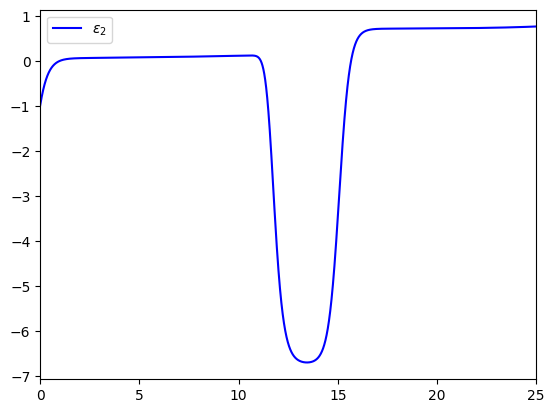

In [7]:
# Plotting second slow-roll parameter to see featured part of the model
plt.xlim(n1, n2)
plt.plot(solb.t, e2_interp(solb.t), color='blue', label=r'$\epsilon_2$')
plt.legend()

In [8]:
# ------------------------------------------------------------------
# 1. Wavenumber sampling
# ------------------------------------------------------------------
# The power spectrum is evaluated over a logarithmically spaced range of comoving wavenumbers k.
#
# k_ini : smallest mode (largest scale)
# k_fin : largest mode (smallest scale)
# nop   : number of k-modes
# increase nop to achieve higher resolution for plots
k_ini = 0.01
k_fin = 5e2
nop = 360
kk = [k_ini * (k_fin / k_ini)**(i / (nop - 1)) for i in range(nop)]

# Scale factor definition
# The scale factor is written in terms of the e-fold number N:
#
#     a(N) = a_end * exp(N - N_end)
#
# The parameter a_end is a free normalization that rescales the horizontal (k) axis of the power spectrum and can be adjusted to match CMB constraints.
aend = 3e7
def a(n):
    return aend*np.exp(n-n2)

# Evaluate horizon-crossing time for each mode
#     k = a(N_hc) * H(N_hc)
n_hc = []
for item in kk:
    try:
        val = brentq(lambda n: item - a(n) * H_interp(n), n1+0.1, n2-0.1)
        n_hc.append(val)
    except ValueError:
        # If no root is found, we assign an early fallback time.
        n_hc.append(n1+1)
# Following Appendix C of arXiv:2301.03600, it is sufficient to start integrating the Mukhanov–Sasaki equation approximately 4 e-folds before horizon crossing, where the mode is deep inside the horizon and Bunch–Davies initial conditions are valid.
n_in = [x - 4 for x in n_hc]

print("Horizon crossing times - 4:", n_in)

# Numba does not work with Python objects or interpolators. We therefore pass all background quantities as raw NumPy arrays.
t_bg_array = t_bg
a_bg = a(t_bg)
e1_bg_array = e1_values
H_bg_array = H_values
zppoz_bg_array = zppoz_values
fp_bg_array = fp_values
fpp_bg_array = fpp_values

# ------------------------------------------------------------------
# 6. Mukhanov–Sasaki equation
# ------------------------------------------------------------------
#
# This equation corresponds to Eq. (C.3) of arXiv:2301.03600 and is written for the canonical variable \bar{v}_k.
# This is used to evaluate exact power spectrum
@njit
def MS_equation(t, v, k, t_bg_arr, e1_bg_arr, H_bg_arr, zppoz_bg_arr, n2_val, aend_val):
    vc = v[0]
    vcp = v[1]
    e1_t = np.interp(t, t_bg_arr, e1_bg_arr)
    H_t = np.interp(t, t_bg_arr, H_bg_arr)
    zppoz_t = np.interp(t, t_bg_arr, zppoz_bg_arr)
    a_t = aend_val * np.exp(t - n2_val)
    damping = (1.0 - e1_t) - (2j * k) / (a_t * H_t)
    dvcdt = vcp
    dvcpdt = -damping * vcp + zppoz_t * vc
    res = np.empty(2, dtype=np.complex128)
    res[0] = dvcdt
    res[1] = dvcpdt
    return res

# This version of the MS equation is written directly for the curvature perturbation R_k.
# It is used to compute:
#   - Adiabatic and non-adiabatic mode functions in equation (8)
#   - Full-gradient interactions (mode = 100)
#
# This equation corresponds to Eq. (2) in the main text.
@njit
def MS_for_modes(n, y, k, t_bg, H_bg, fp_bg, fpp_bg, e1_bg, aend_val, n2_val):
    """
    Numba-compiled MS equation.
    """
    R = y[0]
    Rp = y[1]
    
    # Numba np.interp is fast
    H = np.interp(n, t_bg, H_bg)
    fp = np.interp(n, t_bg, fp_bg)
    fpp = np.interp(n, t_bg, fpp_bg)
    e1 = np.interp(n, t_bg, e1_bg)
    
    curr_a = aend_val * np.exp(n - n2_val)

    friction = 3.0 - e1 + 2.0 * (fpp / fp)
    gradient = (k / (curr_a * H))**2
    
    Rpp = -friction * Rp - gradient * R
    
    out = np.empty(2)
    out[0] = Rp
    out[1] = Rpp
    return out

Horizon crossing times - 4: [0.7211217877023195, 0.751280547253649, 0.7814393609045878, 0.8115982288962877, 0.8417571514717377, 0.8719161288749859, 0.9020751613519851, 0.9322342491500217, 0.9623933925179271, 0.9925525917063167, 1.022711846967006, 1.052871158554236, 1.0830305267215703, 1.1131899517276507, 1.1433494338302186, 1.1735089732892279, 1.2036685703666326, 1.2338282253257074, 1.263987938431553, 1.2941477099510523, 1.3243075401524935, 1.3544674293063377, 1.384627377684323, 1.414787385560234, 1.4449474532098225, 1.475107580909298, 1.5052677689388378, 1.535428017578794, 1.5655883271118594, 1.5957486978226472, 1.6259091299973285, 1.6560696239243367, 1.6862301798932364, 1.7163907981972182, 1.7465514791292929, 1.7767122229853838, 1.8068730300635352, 1.8370339006634326, 1.8671948350864547, 1.8973558336377154, 1.9275168966214542, 1.9576780243462348, 1.9878392171218398, 2.018000475260086, 2.048161799075281, 2.0783231888832896, 2.1084846450024886, 2.138646167753328, 2.1688077574581426, 2.

In [9]:
# ==========================================
# 2. MAIN CALCULATION LOOP
# ==========================================
#
# This section performs the core calculation for a single k‑mode:
#
#   A. Exact power spectrum from direct Mukhanov–Sasaki evolution
#   B. Power spectrum from homogeneous + higher‑order matching
#   C. Power spectrum from δN formalism at various truncation levels
#   D. Power spectrum from δN with full gradient interactions
#   E. Evaluation of equilateral‑type non‑Gaussianity parameter f_NL
#
# The function is designed to be called inside a loop over k‑modes.


# σ = 1 corresponds to matching exactly at horizon crossing:
#     k = σ aH
sigma = 1

def calculate_powers_for_k(i, k):
    # ======================================================
    # A. Exact power spectrum from MS equation
    # ======================================================
    #
    # Solve the Mukhanov–Sasaki equation for the canonical variable v_k from deep inside the horizon until the end of inflation.
    solf = solve_ivp(
        lambda t, v: MS_equation(t, v, k, t_bg_array, e1_bg_array, H_bg_array, zppoz_bg_array, n2, aend),
        (n_in[i], n2 - 0.01), [1.+0.j, 0.+0.j], method='DOP853', rtol=1e-9, atol=1e-10
    )
    # Power spectrum evaluated using Eq. (C.9) of arXiv:2301.03600
    v_end = solf.y[0][-1]
    power_exact_val = k**2 * np.abs(v_end)**2 / (8 * np.pi**2 * e1_end * aend**2)

    # Interpolators for \bar{v}_k and d\bar{v}_k/dN, required at the matching time
    v_bar_interp = interp1d(solf.t, solf.y[0], kind='cubic', bounds_error=False, fill_value="extrapolate")
    vp_bar_interp = interp1d(solf.t, solf.y[1], kind='cubic', bounds_error=False, fill_value="extrapolate")


    # Storage containers for results
    res_l0, res_l1, res_l2, res_l3, res_l4 = [], [], [], [], []
    res_dN0,res_dN1,res_dN2,res_dN3,res_dN4, res_dN = [], [], [], [], [], []
    res_matrices = []
    res_fNL_configs = {}


    # ======================================================
    # B. Matching time and background quantities
    # ======================================================
    #
    # Matching is performed when:
    #     k = σ a(N_match) H(N_match)
    n_match = min(n2 - 0.01, brentq(lambda n: k - sigma * a(n) * H_interp(n), n_in[i], n2 - 0.01))

    # Background quantities at matching time
    phi_m = float(f_interp(n_match))
    phiN_m = float(fp_interp(n_match))
    H_m = H_interp(n_match)
    a_m = a(n_match)
    eta_m = e2_interp(n_match)
    z_m = a_m * phiN_m
    aH_m = a_m * H_m
    tau_m = - 1.0 / aH_m

    # Canonical MS variable and its derivative at matching
    vb_m = v_bar_interp(n_match)
    vbp_m = aH_m * vp_bar_interp(n_match)

    # Convert to positive‑frequency mode using Eq. (C.1)
    v_match = (vb_m / np.sqrt(2*k)) * np.exp(-1j * k * tau_m)
    vp_match = ((vbp_m - 1j * k * vb_m) / np.sqrt(2 * k)) * np.exp(-1j * k * tau_m)

    # Curvature perturbation and its derivative
    R_match = v_match / z_m
    zp_over_z = (1.0 + 0.5 * eta_m) * aH_m
    Rp_match = (vp_match - v_match * zp_over_z) / z_m

    # ======================================================
    # C. Adiabatic and non‑adiabatic mode functions
    # ======================================================
    #
    # These modes are required for the δN formalism with full gradient interactions.
    #
    # Instead of evaluating gradient‑expansion corrections using the recursive relations of Eq. (6), we compute the adiabatic (u_ad) and non‑adiabatic (u_nad) mode functions appearing in Eq. (8) directly from the Mukhanov–Sasaki (MS) equation.
    # This is achieved by solving the MS equation with the followinginitial conditions imposed at the matching time N = N_match:
    #
    #   Adiabatic mode:
    #       (R*, dR*/dN) = (1, 0)
    #
    #   Non‑adiabatic mode:
    #       (R*, dR*/dN) = (0, 1)
    #
    # The curvature power spectrum obtained from the δN formalism using these mode functions as source terms is shown in Fig. 1. The excellent agreement with the exact linear solution from the full Mukhanov–Sasaki equation validates the accuracy and numerical stability of this approach.
    #
    # Adiabatic mode: u_ad(N)
    y0_ad = [1.0, 0.0]
    sol_ad = solve_ivp(lambda t, y: MS_for_modes(t, y, k, t_bg_array, H_bg_array, fp_bg_array, fpp_bg_array, e1_bg_array, aend, n2),
                       (n_match, n2 - 0.01), y0_ad, method='DOP853', rtol=1e-9, atol=1e-10)

    # Non‑adiabatic mode: u_nad(N)
    y0_nad = [0.0, 1.0 / aH_m]
    sol_nad = solve_ivp(lambda t, y: MS_for_modes(t, y, k, t_bg_array, H_bg_array, fp_bg_array, fpp_bg_array, e1_bg_array, aend, n2),
                        (n_match, n2 - 0.01), y0_nad, method='DOP853', rtol=1e-9, atol=1e-10)

    mode_arrays = (sol_ad.t, sol_ad.y[0], sol_nad.t, sol_nad.y[0])
    
    # ======================================================
    # D. Gradient‑expansion integrals
    # ======================================================
    corrections = build_k2_corrections(n_match)

    pre = (k**3 / (2 * np.pi**2))


    # ======================================================
    # E. Homogeneous and higher‑order matching
    # ======================================================
    # Values of nested integrals evaluated at the end of inflation
    val_nad_0  = corrections[0](n2)
    val_ad_k2  = corrections[1](n2)
    val_nad_k2 = corrections[2](n2)
    # val_ad_k4  = corrections[3](n2)
    # val_nad_k4 = corrections[4](n2)

    # Construct curvature perturbation at different truncation orders
    term_base = R_match + (z_m**2 * Rp_match) * val_nad_0
    term_ad_k2 = - (k**2) * R_match * val_ad_k2
    term_nad_k2 = - (k**2) * (z_m**2 * Rp_match) * val_nad_k2
    # term_ad_k4 = + (k**4) * R_match * val_ad_k4
    # term_nad_k4 = + (k**4) * (z_m**2 * Rp_match) * val_nad_k4

    R_0 = term_base
    R_1 = R_0 + term_ad_k2
    R_2 = R_1 + term_nad_k2
    # R_3 = R_2 + term_ad_k4
    # R_4 = R_3 + term_nad_k4

    # Evaluate power from R
    res_l0 = pre * np.abs(R_0)**2
    res_l1= pre * np.abs(R_1)**2
    res_l2 = pre * np.abs(R_2)**2
    # res_l3= pre * np.abs(R_3)**2
    # res_l4 = pre * np.abs(R_4)**2

    # ======================================================
    # F. δN formalism
    # ======================================================
    # Flat‑gauge field perturbations
    dphi_flat = phiN_m * R_match
    dphiN_flat = phiN_m * (eta_m * R_match / 2 + Rp_match / aH_m)
    
    # Phase‑space perturbation vector
    delta_X = np.array([dphi_flat, dphiN_flat], dtype=np.complex128)

    # --- Standard δN (mode = 0)
    grad0, hess0 = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=0)
    z_dN0 = np.dot(delta_X, grad0)
    res_dN0 = pre * np.abs(z_dN0)**2

    # --- Higher‑order truncations
    # mode=1
    grad1, _  = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=1)
    z_dN1 = np.dot(delta_X, grad1)
    res_dN1 = pre * np.abs(z_dN1)**2
    
    # mode=2
    grad2, _  = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=2)
    z_dN2 = np.dot(delta_X, grad2)
    res_dN2 = pre * np.abs(z_dN2)**2
    
    # # mode=3
    # grad3, _  = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=3)
    # z_dN3 = np.dot(grad3, delta_X)
    # res_dN3 = pre * np.abs(z_dN3)**2
    #
    # # mode=4
    # grad4, _  = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=4)
    # z_dN4 = np.dot(grad4, delta_X)
    # res_dN4 = pre * np.abs(z_dN4)**2

    # --- Full gradient interactions (mode = 100)
    grad, hess = get_hessian_and_gradient(n_match, k, H_m, z_m, phi_m, phiN_m, R_match, Rp_match, dphi_flat, dphiN_flat, corrections, mode_arrays, mode=100)

    term_linear = np.dot(delta_X, grad)
    P_R_lin = pre * np.abs(term_linear)**2
    res_dN = P_R_lin
    
    # ======================================================
    # G. Power‑spectrum matrix for non‑Gaussianity
    # ======================================================
    # Matrix of power spectra defined in Eq. (22)
    P_matrix = pre * np.real(np.outer(delta_X, np.conjugate(delta_X)))
    res_matrices = P_matrix
    
    
    
    # ======================================================
    # H. Equilateral‑type f_NL
    # ======================================================
    # Standard δN formalism
    # Numerator of Eq. (24)
    numerator_B = np.einsum('a,b,cd,ac,bd->', grad0, grad0, hess0, P_matrix, P_matrix)
    # Denominator of Eq. (24)
    denominator_P = np.einsum('e,f,ef->', grad0, grad0, P_matrix)
    fNL_val = (5.0 / 6.0) * numerator_B / (denominator_P**2)
    res_fNL_configs["standard"] = fNL_val
    
    # δN with full gradients
    # Subsets of phase‑space variables used in Fig. 2
    configs = {
        "01": [0, 1],   #δN with full gradients
        "0":  [0],      #neglecting contribution of δphi_N
    }

    for name, indices in configs.items():
        grad_sub = grad[indices]
        hess_sub = hess[np.ix_(indices, indices)]
        P_matrix_sub = P_matrix[np.ix_(indices, indices)]

        # Numerator of Eq. (24)
        numerator_B = np.einsum('a,b,cd,ac,bd->', grad_sub, grad_sub, hess_sub, P_matrix_sub, P_matrix_sub)
        # Denominator of Eq. (24)
        denominator_P = np.einsum('e,f,ef->', grad_sub, grad_sub, P_matrix_sub)
        fNL_val = (5.0 / 6.0) * numerator_B / (denominator_P**2)
        res_fNL_configs[name] = fNL_val

    return (power_exact_val,
            res_l0, res_l1, res_l2, res_l3, res_l4,
            res_dN0,res_dN1,res_dN2,res_dN3,res_dN4, res_dN,
            res_matrices, res_fNL_configs)

In [10]:
# ============================================================
# PARALLEL EXECUTION OVER k-MODES
# ============================================================
# Each k-mode is fully independent. We therefore distribute the workload across all available CPU cores.
# The function `calculate_powers_for_k(i, k)` returns a tuple containing all power spectra, matrices, and f_NL values for that particular k.
results = Parallel(n_jobs=-1)(delayed(calculate_powers_for_k)(i, k) for i, k in enumerate(tqdm(kk)))


# ============================================================
# UNPACK RESULTS
# ============================================================
#
# For clarity and downstream plotting, we separate the output into lists ordered by k.
#
# Naming convention:
#   HM_levelX   : Homogeneous / higher-order matching
#   dN_levelX   : δN formalism at truncation level X
#   dN          : δN with full gradient interactions (mode=100)

# --- Exact Mukhanov–Sasaki power spectrum
power_exact = []
# --- Homogeneous / higher-order matching
HM_level0_dict = []
HM_level1_dict = []
HM_level2_dict = []
HM_level3_dict = []
HM_level4_dict = []
# --- δN-based spectra
dN_level0_dict = []
dN_level1_dict = []
dN_level2_dict = []
dN_level3_dict = []
dN_level4_dict = []
dN_dict = []
# --- Power-spectrum matrices (used for non-Gaussianity)
matrices_dict = []

# f_NL STORAGE
config_names = ["01", "0", "standard"]
fNL_results = {name: [] for name in config_names}

# LOOP OVER k-MODES AND COLLECT RESULTS
for r in results:
    power_exact.append(r[0])
    HM_level0_dict.append(r[1])
    HM_level1_dict.append(r[2])
    HM_level2_dict.append(r[3])
    HM_level3_dict.append(r[4])
    HM_level4_dict.append(r[5])
    dN_level0_dict.append(r[6])
    dN_level1_dict.append(r[7])
    dN_level2_dict.append(r[8])
    dN_level3_dict.append(r[9])
    dN_level4_dict.append(r[10])
    dN_dict.append(r[11])
    matrices_dict.append(r[12])
    res_configs = r[13]

    # Unpack fNL configs
    for name in config_names:
        fNL_results[name].append(res_configs[name])

  0%|          | 0/360 [00:00<?, ?it/s]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


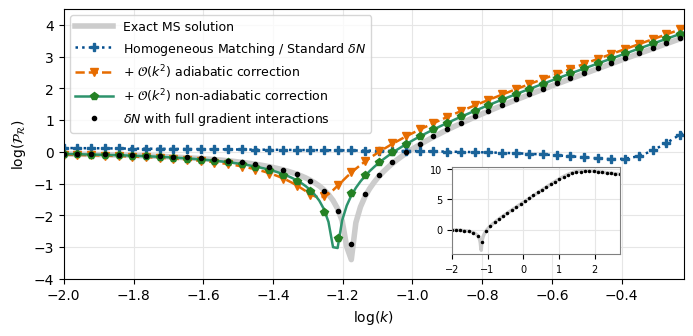

In [11]:
# ==========================================
# 3. PLOTTING POWER SPECTRA (FIG.1)
# ==========================================

# Colors setup
line_colors = ['#004b8d', '#e66c00', '#2d936c', '#8a508f', '#f4a259', '#4361ee']
marker_colors = ['#1a6399', '#e66c00', '#248124', '#b31f1f', '#7b55a5', 'black']
line_styles = [':', '--', 'solid', (0, (3, 1, 1, 1)), (0, (1, 1)), (0, (2, 2))]
marker_styles = ['P', 'v', 'p', '^', '*', 'P']

# Helper to ensure arrays
def to_array(data):
    if isinstance(data, dict):
        return np.array(list(data.values()))
    return np.array(data)

# Convert data to arrays
kk_array = to_array(kk)
power_exact_array = to_array(power_exact)
HM_level0_array = to_array(HM_level0_dict)
HM_level1_array = to_array(HM_level1_dict)
HM_level2_array = to_array(HM_level2_dict)
HM_level3_array = to_array(HM_level3_dict)
HM_level4_array = to_array(HM_level4_dict)
dN_level0_array = to_array(dN_level0_dict)
dN_level1_array = to_array(dN_level1_dict)
dN_level2_array = to_array(dN_level2_dict)
dN_level3_array = to_array(dN_level3_dict)
dN_level4_array = to_array(dN_level4_dict)
dN_array = to_array(dN_dict)

# Create indices for markers
num_markers_main = 120
num_markers_inset = 40
# num_markers_main = nop
# num_markers_inset = nop
total_points = len(kk_array)

k_indices_main = np.linspace(0, total_points-1, min(num_markers_main, total_points), dtype=int)
k_indices_inset = np.linspace(0, total_points-1, min(num_markers_inset, total_points), dtype=int)

# Change of variables for Loglog plots
log_k = np.log10(kk_array)
log_power_exact = np.log10(power_exact_array)

log_HM_level0 = np.log10(HM_level0_array)
log_HM_level1 = np.log10(HM_level1_array)
log_HM_level2 = np.log10(HM_level2_array)
log_HM_level3 = np.log10(HM_level3_array)
log_HM_level4 = np.log10(HM_level4_array)

log_dN_level0 = np.log10(dN_level0_array)
log_dN_level1 = np.log10(dN_level1_array)
log_dN_level2 = np.log10(dN_level2_array)
log_dN_level3 = np.log10(dN_level3_array)
log_dN_level4 = np.log10(dN_level4_array)
log_dN = np.log10(dN_array)

# Limits
k_ini_log = np.log10(k_ini)
k_fin_log = np.log10(k_fin)
main_xmin_log = np.log10(0.01)
main_xmax_log = np.log10(0.6)

# --- Plot Setup ---
plt.figure(figsize=(8, 3.5))
plt.xlim(main_xmin_log, main_xmax_log)
plt.ylim(-4, 4.5)

# Lists to store handles and labels for the custom legend
plot_handles = []
plot_labels = []

class HandlerTupleWithLineStyle(HandlerTuple):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        line, marker = orig_handle

        # Create line proxy with SAME linestyle
        legline = Line2D(
            [xdescent, xdescent + width],
            [ydescent + height / 2] * 2,
            linestyle=line.get_linestyle(),
            linewidth=line.get_linewidth(),
            color=line.get_color(),
        )

        # Create marker proxy
        legmarker = Line2D(
            [xdescent + width / 2],
            [ydescent + height / 2],
            linestyle='none',
            marker=marker.get_marker(),
            markersize=marker.get_markersize(),
            markerfacecolor=marker.get_markerfacecolor(),
            markeredgecolor=marker.get_markeredgecolor(),
            markeredgewidth=marker.get_markeredgewidth(),
        )

        legline.set_transform(trans)
        legmarker.set_transform(trans)

        return [legline, legmarker]

# Helper function to safely plot pairs without crashing on empty data
def plot_pair(k_vals, line_vals, marker_vals, k_idx, l_color, l_syle, m_color, m_style, label_text):
    # Plot line
    lines = plt.plot(k_vals, line_vals, color=l_color, linestyle=l_syle, linewidth=1.8, zorder=2)
    h_line = lines[0] if lines else None
    
    # Plot markers
    markers = plt.plot(k_vals[k_idx], marker_vals[k_idx], linestyle='none', marker=m_style, 
                       markerfacecolor=mcolors.to_rgba(m_color, alpha=1), markeredgecolor=m_color, markersize=6.1)
    h_marker = markers[0] if markers else None
    
    # Only add to legend if both exist (or adapt logic if only one exists)
    if h_line and h_marker:
        plot_handles.append((h_line, h_marker))
        plot_labels.append(label_text)
    elif h_line:
        plot_handles.append(h_line)
        plot_labels.append(label_text)


# 1. Exact Solution
lines_exact = plt.plot(log_k, log_power_exact, color='0.8', linewidth=4, zorder=1)
if lines_exact:
    plot_handles.append(lines_exact[0])
    plot_labels.append('Exact MS solution')

# 2. Level 0 Pair
plot_pair(log_k, log_HM_level0, log_dN_level0, k_indices_main, 
          line_colors[0], line_styles[0], marker_colors[0], marker_styles[0], r'Homogeneous Matching / Standard $\delta N$')

# 3. Level 1 Pair
plot_pair(log_k, log_HM_level1, log_dN_level1, k_indices_main, 
          line_colors[1], line_styles[1], marker_colors[1], marker_styles[1], r'+ $\mathcal{O}(k^2)$ adiabatic correction')

# 4. Level 2 Pair
plot_pair(log_k, log_HM_level2, log_dN_level2, k_indices_main, 
          line_colors[2], line_styles[2], marker_colors[2], marker_styles[2], r'+ $\mathcal{O}(k^2)$ non-adiabatic correction')

# 5. Level 3 Pair
plot_pair(log_k, log_HM_level3, log_dN_level3, k_indices_main, 
          line_colors[3], line_styles[3], marker_colors[3], marker_styles[3], r'+ $\mathcal{O}(k^4)$ non-adiabatic correction')

# 6. Level 4 Pair
plot_pair(log_k, log_HM_level4, log_dN_level4, k_indices_main, 
          line_colors[4], line_styles[4], marker_colors[4], marker_styles[4], r'+ $\mathcal{O}(k^4)$ non-adiabatic correction')

# 7. Final Unique dN
if len(k_indices_main) > 0:
    h_final_list = plt.plot(log_k[k_indices_main], log_dN[k_indices_main], linestyle='none', marker='.', 
                        markeredgecolor=marker_colors[5], markersize=6, markerfacecolor=marker_colors[5])
    if h_final_list:
        plot_handles.append(h_final_list[0])
        plot_labels.append(r'$\delta N$ with full gradient interactions')

# Labels and Grid
plt.xlabel(r'$\log(k)$', fontsize=10)
plt.ylabel(r'$\log(\mathcal{P}_{\mathcal{R}})$', fontsize=10)
plt.grid(True, which="both", ls="-", color='0.9', zorder=0)
ax = plt.gca()
ax.set_axisbelow(True)

# --- CUSTOM LEGEND ---
if plot_handles:
    plt.legend(
    handles=plot_handles,
    labels=plot_labels,
    loc='upper left',
    fontsize=9,
    handlelength=3,
    handler_map={tuple: HandlerTupleWithLineStyle()}
)

# --- INSET PLOT ---
inset_ax = plt.axes([0.61, 0.18, 0.21, 0.25]) 

# Function for safe inset plotting
def safe_plot_inset(x, y, **kwargs):
    if len(x) > 0 and len(y) > 0:
        inset_ax.plot(x, y, **kwargs)

# Plot Lines in Inset
safe_plot_inset(log_k, log_power_exact, color='0.8', linewidth=2.5, zorder=1)
# safe_plot_inset(log_k, log_HM_level0, color=line_colors[0], linestyle='-', linewidth=1.5, zorder=2)
# safe_plot_inset(log_k, log_HM_level1, color=line_colors[1], linestyle='-', linewidth=1.5, zorder=2)
# safe_plot_inset(log_k, log_HM_level2, color=line_colors[2], linestyle='-', linewidth=1.5, zorder=2)
# safe_plot_inset(log_k, log_HM_level3, color=line_colors[3], linestyle='-', linewidth=1.5, zorder=2)
# safe_plot_inset(log_k, log_HM_level4, color=line_colors[4], linestyle='-', linewidth=1.5, zorder=2)

# Plot Markers in Inset

# safe_plot_inset(log_k[k_indices_inset], log_dN_level0[k_indices_inset], linestyle='none', marker='o', 
#               markerfacecolor='none', markeredgecolor=marker_colors[0], markersize=4, markeredgewidth=0.8)
# safe_plot_inset(log_k[k_indices_inset], log_dN_level1[k_indices_inset], linestyle='none', marker='o', 
#               markerfacecolor='none', markeredgecolor=marker_colors[1], markersize=4, markeredgewidth=0.8)
# safe_plot_inset(log_k[k_indices_inset], log_dN_level2[k_indices_inset], linestyle='none', marker='o', 
#               markerfacecolor='none', markeredgecolor=marker_colors[2], markersize=4, markeredgewidth=0.8)
# safe_plot_inset(log_k[k_indices_inset], log_dN_level3[k_indices_inset], linestyle='none', marker='o', 
#               markerfacecolor='none', markeredgecolor=marker_colors[3], markersize=4, markeredgewidth=0.8)
# safe_plot_inset(log_k[k_indices_inset], log_dN_level4[k_indices_inset], linestyle='none', marker='o', 
#               markerfacecolor='none', markeredgecolor=marker_colors[4], markersize=4, markeredgewidth=0.8)
safe_plot_inset(log_k[k_indices_inset], log_dN[k_indices_inset], linestyle='none', marker='.', 
              markeredgecolor=marker_colors[5], markersize=3, markerfacecolor=marker_colors[5])

# Inset styling
inset_ax.set_xlim(k_ini_log, k_fin_log)
inset_ax.set_ylim(auto=True)
inset_ax.grid(True, which="both", ls="-", color='0.9', zorder=0)
inset_ax.tick_params(axis='both', which='both', labelsize=7)
inset_ax.set_axisbelow(True)

#inset_ax.set_title('Full range', fontsize=8)
for spine in inset_ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.8)

# Save diagram as png and eps file
plt.savefig("power_spectrum_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("power_spectrum_comparison.eps", format="eps", bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


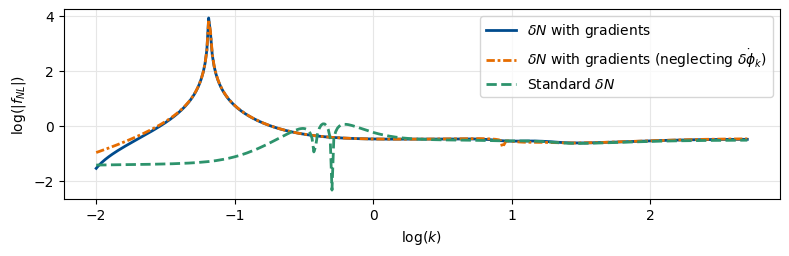

In [12]:
# ==========================================
# 3. PLOTTING fNL (FIG.2)
# ==========================================
# Define styles for each config to differentiate them clearly
styles = {
    "01": {'lcolor': '#004b8d', 'ls': 'solid', 'label': r'$\delta N$ with gradients'},
    "0": {'lcolor': '#e66c00', 'ls': (0, (3, 1, 1, 1)), 'label': r'$\delta N$ with gradients (neglecting $\dot{\delta \phi}_{k}$)'},
    "standard":  {'lcolor': '#2d936c', 'ls': '--', 'label': r'Standard $\delta N$'}
}

plt.figure(figsize=(8, 8/3))

k_new = np.log10(kk)

for name in config_names:
    style = styles[name]
    lbl = fr"{style['label']}"
    y_new = np.log10(np.abs(fNL_results[name]))    
    plt.plot(k_new, y_new,
             linestyle=style['ls'], color=style['lcolor'], lw=2, label=lbl)

plt.xlabel(r'$\log(k)$', fontsize=10)
plt.ylabel(r'$\log(|f_{NL}|)$', fontsize=10)

plt.legend(loc='upper right', handlelength=2.2)
plt.grid(True, which="both", ls="-", color='0.9')
ax = plt.gca()
ax.set_axisbelow(True)
plt.tight_layout()

# Save the diagram as png and eps
plt.savefig("fNL_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("fNL_comparison.eps", format="eps", bbox_inches="tight")
plt.show()

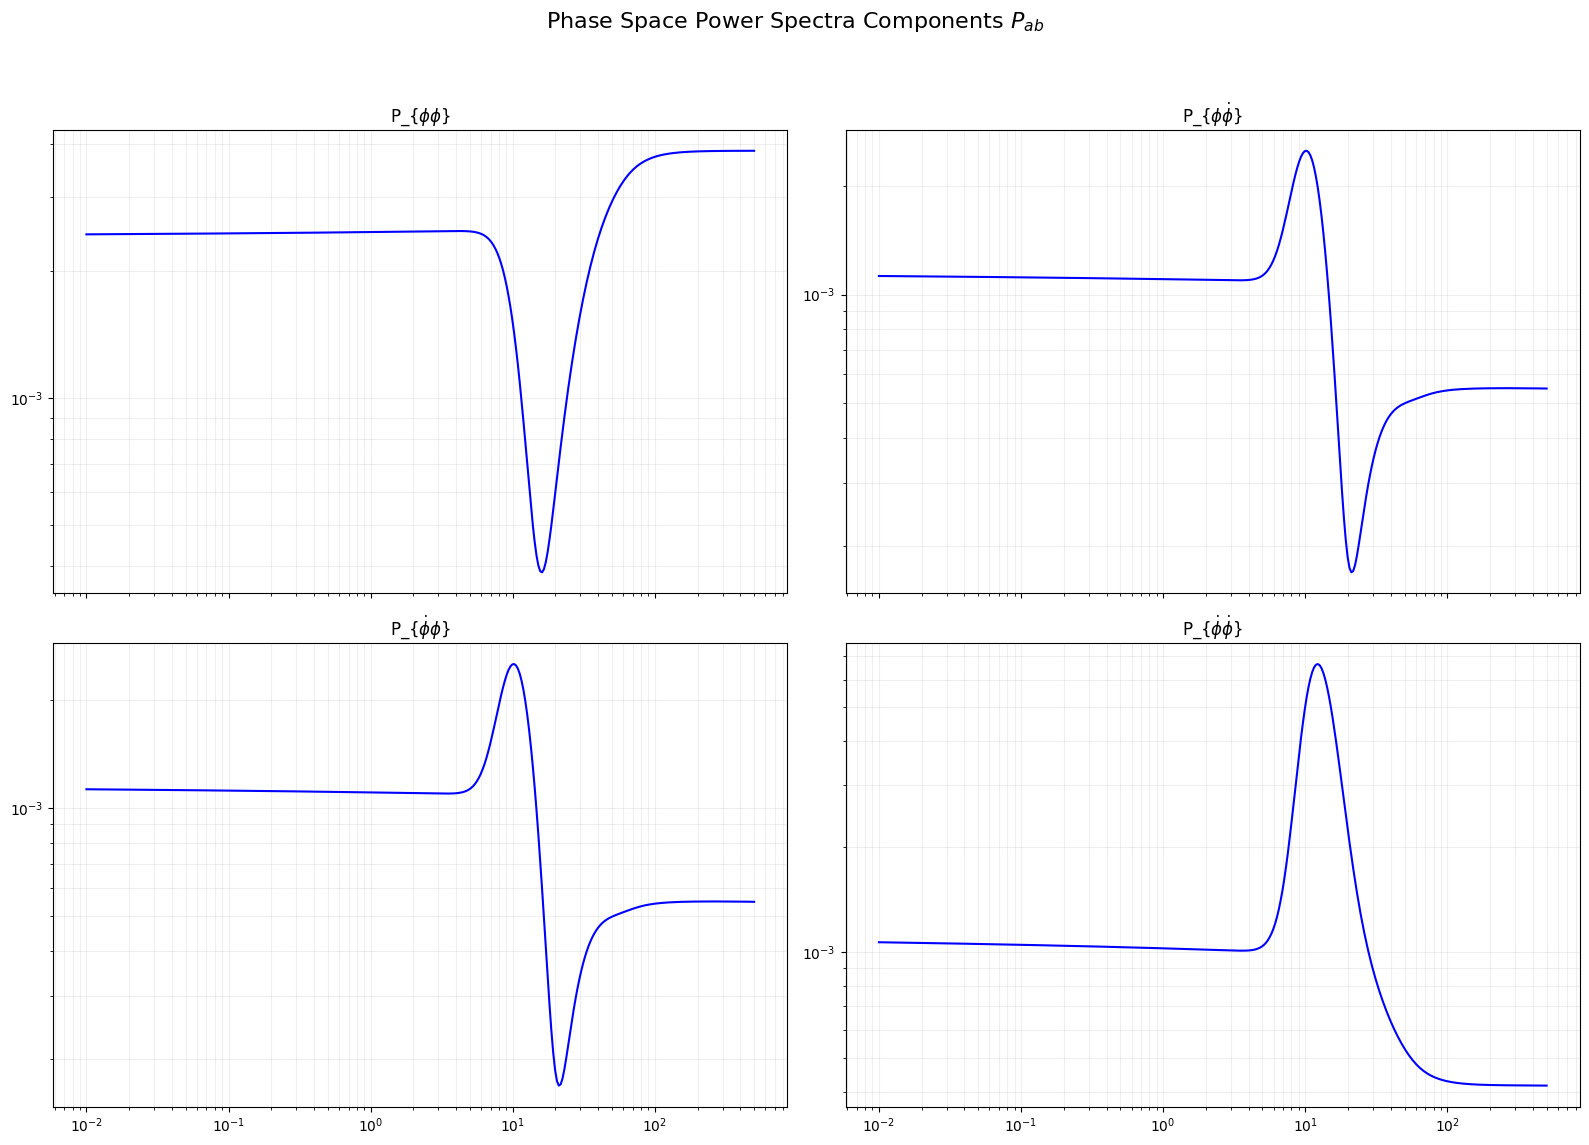

In [13]:
# ==========================================
# 3. PLOTTING 4 POWER SPECTRA (EQUATION 23)
# ==========================================
# We will plot the components P_ab vs k
P_data_series = matrices_dict # List of N_k matrices (4x4)

# Convert list of matrices to array of shape (N_k, 4, 4)
P_array = np.array(P_data_series) 

labels = [r'$\phi$', r'$\dot{\phi}$', r'$\mathcal{R}$', r'$\mathcal{R}^\prime$']

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)
fig.suptitle(fr'Phase Space Power Spectra Components $P_{{ab}}$', fontsize=16)

for r in range(2):
    for c in range(2):
        ax = axes[r, c]
        y_vals = P_array[:, r, c]
        # Let's plot absolute value loglog
        ax.loglog(kk, np.abs(y_vals), 'b-')

        ax.set_title(f'P_{{{labels[r]}{labels[c]}}}')
        ax.grid(True, which="both", ls="-", alpha=0.2)

        if r == 3:
            ax.set_xlabel('k')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("Phase Space Power Spectra Components.png", dpi=300, bbox_inches="tight")
plt.show()